# Marketing Mix Modeling
**Author**: [Alex FitzGerald](https://www.linkedin.com/in/alex-fitzgerald-0734076a/)
![MMM header](Images/mmm_hero_image.png)

## Overview
Media Mix Modeling is an analysis technique to understand and quantify the impact that advertising has on its desired goal, typically sales of the product being promoted. This project focuses on media mix modeling with different linear regression techniques of varying complexities. This work builds off of the work done by [Dr. Robert Kübler](https://github.com/Garve?tab=repositories) adding additional analysis tools marketers to implement in real-world scenarios.

## Business Problem
It has been said that 50% of advertising spend is wasted, the trouble is knowing which half. Advertisers need to understand where to allocate their marketing budgets to maximize ROI (return on advertising spend). In a world with limited budgets and many available channels, wasting 50% of your investment simply isn't good enough. Smart media planning begins with an informed ROI prediction across your advertising channels. Media Mix Modeling uses the historical data from the advertiser to draw connections between spend (X) and sales (y). These connections not only help illuminate the ROI of past investments, they unlock the ability to optimize future media plans.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.utils.validation import check_is_fitted, check_array
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

## Creating a Saturation Effect

a = hyperparameter controling shape of saturation curve (a>0)

X = spend

saturation effect = 1-exp(a*X)

In [3]:
#with check for a greater than 0
class ExponentialSaturation(BaseEstimator,TransformerMixin):
    def __init__(self,a=.0010):
        if a > 0:
            self.a = a
        else:
            self.a = 1
    def fit(self,X,y=None):
        X = check_array(X)
        self._check_n_features(X,reset=True)
        return self
    def transform(self,X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X,reset=False)

        return 1 - np.exp(-self.a*X)

In [4]:
spend_df = data.copy()
spend_df.drop(columns=list(data.columns)[0:4],inplace=True)
spend_df["Spend_total"] = data["TV"]+data["Radio"]+data["Banners"]
spend_df

,Spend_total
Date,
2018-01-07,13528.10
2018-01-14,7568.58
2018-01-21,6282.82
2018-01-28,3562.21
2018-02-04,2187.29
...,...
2021-10-03,1691.68
2021-10-10,18677.81
2021-10-17,6475.35


In [5]:
SE = ExponentialSaturation()
spend_df["Saturated_spends"] = SE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends
Date,,
2018-01-07,13528.10,0.999999
2018-01-14,7568.58,0.999484
2018-01-21,6282.82,0.998132
2018-01-28,3562.21,0.971624
2018-02-04,2187.29,0.887780
...,...,...
2021-10-03,1691.68,0.815790
2021-10-10,18677.81,1.000000
2021-10-17,6475.35,0.998459


''

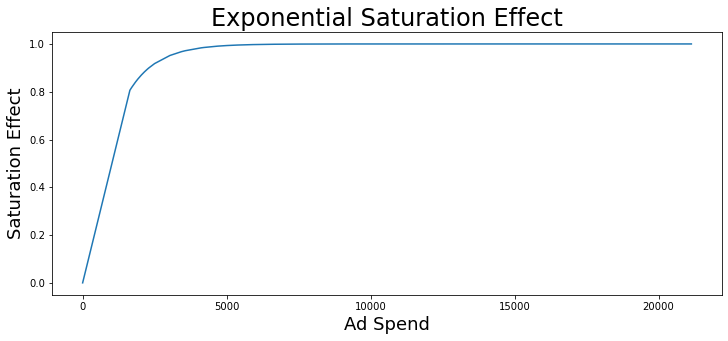

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(ax=ax,x=spend_df["Spend_total"],y=spend_df["Saturated_spends"])
ax.set_title('Exponential Saturation Effect',fontsize=24)
plt.xlabel('Ad Spend',fontsize=18)
plt.ylabel('Saturation Effect',fontsize=18)
plt.subplots_adjust(bottom=0.15)
#sns.set(font_scale = 1)
plt.savefig('Images/exp_saturation_effect.png')
;

## Carry-Over Effect

In [7]:
from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [8]:
CE = ExponentialCarryover()
spend_df["Carried_spends"] = CE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends,Carried_spends
Date,,,
2018-01-07,13528.10,0.999999,13528.100
2018-01-14,7568.58,0.999484,14332.630
2018-01-21,6282.82,0.998132,10067.110
2018-01-28,3562.21,0.971624,6703.620
2018-02-04,2187.29,0.887780,3968.395
...,...,...,...
2021-10-03,1691.68,0.815790,4070.670
2021-10-10,18677.81,1.000000,19523.650
2021-10-17,6475.35,0.998459,15814.255


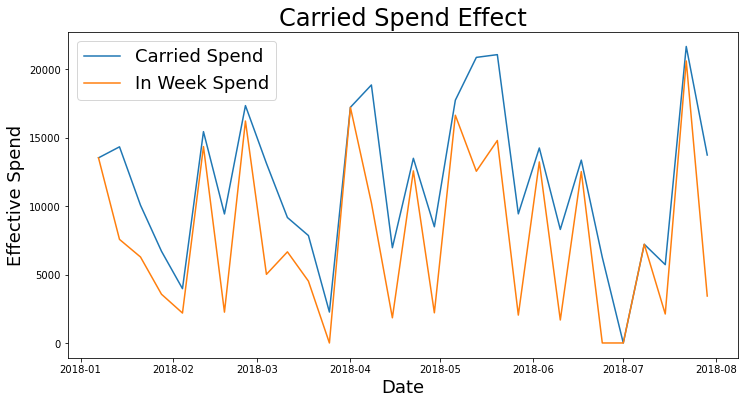

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=spend_df[0:30].index,y=spend_df[0:30]["Carried_spends"])
sns.lineplot(x=spend_df[0:30].index,y=spend_df[0:30]["Spend_total"])
ax.set_xlabel("Date",fontsize=18)
ax.set_ylabel("Effective Spend",fontsize=18)
ax.set_title("Carried Spend Effect",fontsize=24)
ax.legend(["Carried Spend","In Week Spend"],fontsize=18)
plt.savefig('Images/Carried_spend_effect.png');

In [10]:
spend_df[0:5]

,Spend_total,Saturated_spends,Carried_spends
Date,,,
2018-01-07,13528.10,0.999999,13528.100
2018-01-14,7568.58,0.999484,14332.630
2018-01-21,6282.82,0.998132,10067.110
2018-01-28,3562.21,0.971624,6703.620
2018-02-04,2187.29,0.887780,3968.395


## Pipeline

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [12]:
adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)

In [13]:
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [14]:
model.fit(X,y)

Pipeline(steps=[('adstock',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tv_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['TV']),
                                                 ('radio_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                

In [15]:
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.6424114613881203


In [16]:
pred_v_actual_df = pd.DataFrame(data=model.predict(X),columns=["Predicted Sales"],index=X.index)
pred_v_actual_df["Actual Sales"]=y
pred_v_actual_df

,Predicted Sales,Actual Sales
Date,,
2018-01-07,8752.855907,9779.80
2018-01-14,13440.967192,13245.19
2018-01-21,9863.852345,12022.66
2018-01-28,8869.067009,8846.95
2018-02-04,9325.383330,9797.07
...,...,...
2021-10-03,9245.573170,9030.17
2021-10-10,13667.242163,15904.11
2021-10-17,13650.316861,12839.29


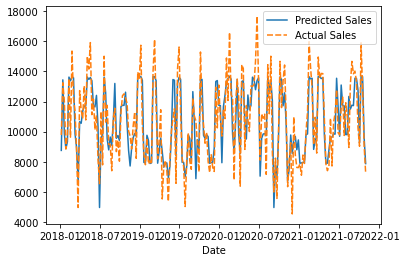

In [17]:
sns.lineplot(data=pred_v_actual_df);

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


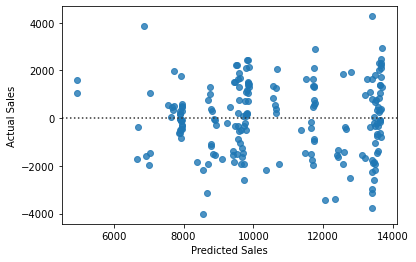

In [18]:
sns.residplot("Predicted Sales","Actual Sales",data=pred_v_actual_df);

## Grid search w/ Optuna

In [19]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution
from optuna.distributions import UniformDistribution, IntUniformDistribution

tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)


<ipython-input-19-063f0165faf0>:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model = OptunaSearchCV(


In [20]:
tuned_model.fit(X,y)

[I 2022-10-13 15:42:50,600] A new study created in memory with name: no-name-89eafe52-2629-40d8-8b41-bb2c33f1f461
[I 2022-10-13 15:42:50,650] Trial 0 finished with value: 0.13779163981195114 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: 0.13779163981195114.
[I 2022-10-13 15:42:50,697] Trial 1 finished with value: -7.206841484775084e+17 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0

[I 2022-10-13 15:42:51,340] Trial 13 finished with value: 0.5294254293595316 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03484838613823089, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007515109949576203, 'adstock__radio_pipe__carryover__strength': 0.06434091848136951, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004169507569226943, 'adstock__banners_pipe__carryover__strength': 0.9992866967535542, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0035172201615055474}. Best is trial 11 with value: 0.5759188916436804.
[I 2022-10-13 15:42:51,403] Trial 14 finished with value: 0.6419576763129411 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1293727365984736, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007942340920804446, 'adstock__radio_pipe__carryover__strength': 0.3760710906749566, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:42:52,165] Trial 26 finished with value: 0.5401489721742487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9568918478478259, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007717148185238824, 'adstock__radio_pipe__carryover__strength': 0.7292940211579039, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0021624836510699265, 'adstock__banners_pipe__carryover__strength': 0.7396951876502812, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.005494992206342406}. Best is trial 17 with value: 0.6674883324700226.
[I 2022-10-13 15:42:52,228] Trial 27 finished with value: 0.5623904746185098 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20586925156508742, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006532169033180348, 'adstock__radio_pipe__carryover__strength': 0.984650917089326, 'adstock__radio_pipe__carryover__

[I 2022-10-13 15:42:53,088] Trial 39 finished with value: 0.5727253625866734 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5163282036570265, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006046007334627433, 'adstock__radio_pipe__carryover__strength': 0.22603650296327227, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.001399587681176526, 'adstock__banners_pipe__carryover__strength': 0.12037987128756994, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.003548825977555077}. Best is trial 35 with value: 0.6820541950277945.
[I 2022-10-13 15:42:53,150] Trial 40 finished with value: 0.3683981174646023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.404297331870517, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0028153766017436446, 'adstock__radio_pipe__carryover__strength': 0.3152712159346233, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:42:53,899] Trial 52 finished with value: 0.7965821934224128 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6908103049726186, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0032018228837864416, 'adstock__radio_pipe__carryover__strength': 0.11980445202269874, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0004932803916013334, 'adstock__banners_pipe__carryover__strength': 0.11583703032521153, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006329060557662189}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-13 15:42:53,962] Trial 53 finished with value: 0.7010939590430525 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7086369589674, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0035067876310144654, 'adstock__radio_pipe__carryover__strength': 0.1315381943569255, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:42:54,718] Trial 65 finished with value: 0.4766460834555898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.771828100604462, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0025121170717417674, 'adstock__radio_pipe__carryover__strength': 0.38535243968570315, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0010572371746066173, 'adstock__banners_pipe__carryover__strength': 0.26804682854249184, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006484229716088645}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-13 15:42:54,781] Trial 66 finished with value: 0.4652649419564616 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7343679998256298, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.005265862217149186, 'adstock__radio_pipe__carryover__strength': 0.5781198884001959, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:42:55,542] Trial 78 finished with value: 0.772175862690288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4897966315514423, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.002499361200410164, 'adstock__radio_pipe__carryover__strength': 0.24073499107996363, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007156080826907162, 'adstock__banners_pipe__carryover__strength': 0.20496893985837872, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004660344441250365}. Best is trial 52 with value: 0.7965821934224128.
[I 2022-10-13 15:42:55,606] Trial 79 finished with value: 0.46985940601364035 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48070194810608924, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0010111267325531624, 'adstock__radio_pipe__carryover__strength': 0.17482403646884648, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:42:56,362] Trial 91 finished with value: 0.7834494245290112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5231912540704411, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0006511036943977293, 'adstock__radio_pipe__carryover__strength': 0.303117088718245, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00847785250531151, 'adstock__banners_pipe__carryover__strength': 0.24696105477064817, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007120373124440654}. Best is trial 89 with value: 0.871679840117209.
[I 2022-10-13 15:42:56,426] Trial 92 finished with value: 0.7791876462743738 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5068116463068474, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.000778619446617988, 'adstock__radio_pipe__carryover__strength': 0.30153350498732345, 'adstock__radio_pipe__carryover__l

[I 2022-10-13 15:42:57,187] Trial 104 finished with value: 0.8525839904850064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3177381085560518, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0002966039947073175, 'adstock__radio_pipe__carryover__strength': 0.33019178442018193, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0098358306468154, 'adstock__banners_pipe__carryover__strength': 0.48025957167196187, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008692356319099159}. Best is trial 96 with value: 0.8779885664875874.
[I 2022-10-13 15:42:57,251] Trial 105 finished with value: 0.8948233019013806 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32627136227447245, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0002116588400308534, 'adstock__radio_pipe__carryover__strength': 0.3621344574411935, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:42:58,019] Trial 117 finished with value: 0.7950818751071249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34702007361039666, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007098171477629707, 'adstock__radio_pipe__carryover__strength': 0.43843365477332025, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008597825298061693, 'adstock__banners_pipe__carryover__strength': 0.5647118014288024, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009762305142088009}. Best is trial 109 with value: 0.8982114061266617.
[I 2022-10-13 15:42:58,083] Trial 118 finished with value: 0.818163736840523 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22997663853076772, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0011265964554491806, 'adstock__radio_pipe__carryover__strength': 0.4084910064513727, 'adstock__radio_pipe__carry

[I 2022-10-13 15:42:58,851] Trial 130 finished with value: 0.6756494092007062 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36145409935026385, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0014428904747223702, 'adstock__radio_pipe__carryover__strength': 0.5530805894103966, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008977594923910297, 'adstock__banners_pipe__carryover__strength': 0.4344986395836217, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00919691897191336}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:42:58,916] Trial 131 finished with value: 0.8972142428661574 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29280027611262804, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00017752897316588968, 'adstock__radio_pipe__carryover__strength': 0.45592444332056586, 'adstock__radio_pipe__carr

[I 2022-10-13 15:42:59,689] Trial 143 finished with value: 0.896798660505872 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3459979663383207, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0002468834807763411, 'adstock__radio_pipe__carryover__strength': 0.49112222625248103, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009468404158119118, 'adstock__banners_pipe__carryover__strength': 0.5398828790205887, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009602478012141525}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:42:59,771] Trial 144 finished with value: 0.8477434114309517 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2619386212638026, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0006743182109969286, 'adstock__radio_pipe__carryover__strength': 0.497716033617498, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:00,564] Trial 156 finished with value: 0.7600922262553211 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3518843392740135, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008751069210842728, 'adstock__radio_pipe__carryover__strength': 0.49598967491832047, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0075102808282228525, 'adstock__banners_pipe__carryover__strength': 0.5146043186135948, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009699837444893816}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:43:00,629] Trial 157 finished with value: 0.8728104776465775 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30443481420758245, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0004122247889282695, 'adstock__radio_pipe__carryover__strength': 0.5414431941443715, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:01,416] Trial 169 finished with value: 0.7410663985352441 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35813561805442695, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.000958452781773477, 'adstock__radio_pipe__carryover__strength': 0.44353596100415116, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007475685686697451, 'adstock__banners_pipe__carryover__strength': 0.5575859585177178, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009038833932746685}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:43:01,480] Trial 170 finished with value: 0.6699010711072629 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4057574849625583, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00028729329833617465, 'adstock__radio_pipe__carryover__strength': 0.48724423138100137, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:02,268] Trial 182 finished with value: 0.900753181367104 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3300255569441071, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00022634137043821333, 'adstock__radio_pipe__carryover__strength': 0.4647974628934875, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00910854730266651, 'adstock__banners_pipe__carryover__strength': 0.4870141573799829, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009141354816972539}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:43:02,334] Trial 183 finished with value: 0.8755378567303944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33442094015331264, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 8.44792505653785e-06, 'adstock__radio_pipe__carryover__strength': 0.4718453858225078, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:03,129] Trial 195 finished with value: 0.8213966172294823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33487216057879726, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006075810638968258, 'adstock__radio_pipe__carryover__strength': 0.4188033522579154, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008800750717453017, 'adstock__banners_pipe__carryover__strength': 0.4661386742305582, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009238161567278504}. Best is trial 129 with value: 0.9071029414360684.
[I 2022-10-13 15:43:03,195] Trial 196 finished with value: 0.9052111891818624 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3656789370810763, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019758925984232652, 'adstock__radio_pipe__carryover__strength': 0.4767639572317762, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:03,997] Trial 208 finished with value: 0.9072199990716994 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42160538225130145, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 9.192232753973392e-06, 'adstock__radio_pipe__carryover__strength': 0.5121994740570674, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008519132415292707, 'adstock__banners_pipe__carryover__strength': 0.46160737063264684, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008422144421270707}. Best is trial 207 with value: 0.912163645636111.
[I 2022-10-13 15:43:04,065] Trial 209 finished with value: 0.8355409618777966 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3941262902909278, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00040627300676411105, 'adstock__radio_pipe__carryover__strength': 0.5174598672562273, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:04,868] Trial 221 finished with value: 0.9184259243190823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4277908194309537, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 3.6201050345796184e-05, 'adstock__radio_pipe__carryover__strength': 0.6075083998959413, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008377579055237465, 'adstock__banners_pipe__carryover__strength': 0.4292786605094281, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007930257493773244}. Best is trial 217 with value: 0.922551712488821.
[I 2022-10-13 15:43:04,936] Trial 222 finished with value: 0.9212308983582582 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4259412073083354, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 5.204273943187504e-05, 'adstock__radio_pipe__carryover__strength': 0.6254495391991766, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:05,746] Trial 234 finished with value: 0.9198025025000323 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46266285859978096, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.856394227553704e-05, 'adstock__radio_pipe__carryover__strength': 0.6412837049717085, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008275827553373175, 'adstock__banners_pipe__carryover__strength': 0.40863219047542115, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0077298229567217824}. Best is trial 228 with value: 0.9254897738346344.
[I 2022-10-13 15:43:05,815] Trial 235 finished with value: 0.9266708849405786 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4681377139610731, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 5.451858527070749e-05, 'adstock__radio_pipe__carryover__strength': 0.6432709135515371, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:06,630] Trial 247 finished with value: 0.9247938119265641 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4832016431479409, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 2.8354458096525848e-05, 'adstock__radio_pipe__carryover__strength': 0.644296889744989, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00817491752201542, 'adstock__banners_pipe__carryover__strength': 0.33758117298245793, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007815962553180919}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:06,697] Trial 248 finished with value: 0.9225167829964404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48352237741812093, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.9103681551842944e-05, 'adstock__radio_pipe__carryover__strength': 0.6458418930465999, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:07,513] Trial 260 finished with value: 0.9116801276815949 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4558145978529292, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.9871570617463463e-06, 'adstock__radio_pipe__carryover__strength': 0.6783317115219926, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007953415171375147, 'adstock__banners_pipe__carryover__strength': 0.3298600087040367, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007869760333705227}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:07,582] Trial 261 finished with value: 0.8425436556235899 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4782475185171974, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00025899418300292284, 'adstock__radio_pipe__carryover__strength': 0.7552001074347059, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:08,419] Trial 273 finished with value: 0.8261079346112439 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4501810322185604, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00033161269066502984, 'adstock__radio_pipe__carryover__strength': 0.665055241705496, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008084364563819687, 'adstock__banners_pipe__carryover__strength': 0.36361743137802766, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008330614781919536}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:08,492] Trial 274 finished with value: 0.820367296327769 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4913905990475256, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 2.4788824793514337e-06, 'adstock__radio_pipe__carryover__strength': 0.6507902342732926, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:09,451] Trial 286 finished with value: 0.5662001495401986 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5578688034467585, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005133656189487294, 'adstock__radio_pipe__carryover__strength': 0.633240446119666, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00860248949940172, 'adstock__banners_pipe__carryover__strength': 0.4192893389160754, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007279904997591451}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:09,522] Trial 287 finished with value: 0.9118741176153691 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4337190856671414, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.2717157905196128e-05, 'adstock__radio_pipe__carryover__strength': 0.8302349084547258, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:10,405] Trial 299 finished with value: 0.6206719372033718 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5478043202220678, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019481338784811824, 'adstock__radio_pipe__carryover__strength': 0.6109642585696913, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.008294284854831468, 'adstock__banners_pipe__carryover__strength': 0.36271131520850175, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00789341566143158}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:10,478] Trial 300 finished with value: 0.7316471619603957 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46348060822532877, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005191474577034835, 'adstock__radio_pipe__carryover__strength': 0.640576582931553, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:11,313] Trial 312 finished with value: 0.9127341825446604 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45407254807705016, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 4.8345447580829914e-06, 'adstock__radio_pipe__carryover__strength': 0.5996413300878162, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008294921048269883, 'adstock__banners_pipe__carryover__strength': 0.4480106550525042, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007661868505926413}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:11,381] Trial 313 finished with value: 0.5999240956828175 and parameters: {'adstock__tv_pipe__carryover__strength': 0.470368550949956, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00037413193687239665, 'adstock__radio_pipe__carryover__strength': 0.6369850155426293, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:12,217] Trial 325 finished with value: 0.9088862796338566 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4350195918787907, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 5.473427794048686e-06, 'adstock__radio_pipe__carryover__strength': 0.839631518737673, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008689208572007135, 'adstock__banners_pipe__carryover__strength': 0.4375155348020622, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00803829733230836}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:12,286] Trial 326 finished with value: 0.8828177123429495 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48024907626978713, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000184170954553524, 'adstock__radio_pipe__carryover__strength': 0.557187497552008, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:43:13,145] Trial 338 finished with value: -1280.1525838634627 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5578906896684055, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007584384051832261, 'adstock__radio_pipe__carryover__strength': 0.7055693804115755, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00833580301183965, 'adstock__banners_pipe__carryover__strength': 0.41698600111121076, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007707861215862571}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:13,215] Trial 339 finished with value: 0.7854866577431018 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4501500870153464, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020357136655655154, 'adstock__radio_pipe__carryover__strength': 0.5961533809094959, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:14,063] Trial 351 finished with value: 0.9016031950459226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44336282756354006, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017203955256424991, 'adstock__radio_pipe__carryover__strength': 0.5927549790166232, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008685268907949815, 'adstock__banners_pipe__carryover__strength': 0.3581330986205758, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008599928804858936}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:14,133] Trial 352 finished with value: 0.9220763221461331 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5163530917613908, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.2869775233740783e-05, 'adstock__radio_pipe__carryover__strength': 0.7329860839555709, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:15,007] Trial 364 finished with value: 0.9207716020881616 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5244026033361824, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 9.162654199281408e-06, 'adstock__radio_pipe__carryover__strength': 0.6808527945676198, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00857719997416348, 'adstock__banners_pipe__carryover__strength': 0.4318096974840426, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008250241296048252}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:15,078] Trial 365 finished with value: 0.5296692235148601 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5416103258953798, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006388662682767737, 'adstock__radio_pipe__carryover__strength': 0.7222579751383882, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:15,934] Trial 377 finished with value: 0.640790974376627 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42692107501208326, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004553884986659139, 'adstock__radio_pipe__carryover__strength': 0.5783818742458702, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008047253759247457, 'adstock__banners_pipe__carryover__strength': 0.355626824518087, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.007947567840551305}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:16,005] Trial 378 finished with value: 0.655704745716911 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4797871277508002, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006558101770009949, 'adstock__radio_pipe__carryover__strength': 0.6386738433882073, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:43:16,877] Trial 390 finished with value: 0.176319303457462 and parameters: {'adstock__tv_pipe__carryover__strength': 0.533129276365085, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0007368556871653139, 'adstock__radio_pipe__carryover__strength': 0.6506900718093788, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0059828945371306706, 'adstock__banners_pipe__carryover__strength': 0.3713157571769935, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.007999203322656578}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:16,949] Trial 391 finished with value: 0.8141393398467688 and parameters: {'adstock__tv_pipe__carryover__strength': 0.392245432373483, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00047885910438308273, 'adstock__radio_pipe__carryover__strength': 0.5753392646248607, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:17,821] Trial 403 finished with value: 0.8683217817067451 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4851336861845599, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020584374373275408, 'adstock__radio_pipe__carryover__strength': 0.5648819325331061, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0027501651783755393, 'adstock__banners_pipe__carryover__strength': 0.33499952586344517, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007918196014676119}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:17,894] Trial 404 finished with value: 0.7586780951783251 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44115921712567047, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005154404600822657, 'adstock__radio_pipe__carryover__strength': 0.741036718698144, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:18,772] Trial 416 finished with value: -0.18198335201204108 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47893836744003526, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0029785048579713054, 'adstock__radio_pipe__carryover__strength': 0.595714745670378, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0075731256280411425, 'adstock__banners_pipe__carryover__strength': 0.39780478114154466, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00816434755791335}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:18,844] Trial 417 finished with value: 0.9099507156895623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4488690181807945, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.331637091254304e-06, 'adstock__radio_pipe__carryover__strength': 0.6126777819809645, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:19,714] Trial 429 finished with value: 0.9190779319414265 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5157047397629598, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 4.401413397587829e-06, 'adstock__radio_pipe__carryover__strength': 0.7130233312096802, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008013554222547679, 'adstock__banners_pipe__carryover__strength': 0.40490650276420814, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008903071759951978}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:19,788] Trial 430 finished with value: 0.63489570059719 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5172522357124966, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005495601732732946, 'adstock__radio_pipe__carryover__strength': 0.7344176467330767, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:20,701] Trial 442 finished with value: 0.8654897634725633 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4920211669052168, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020371773695212542, 'adstock__radio_pipe__carryover__strength': 0.7067029921087258, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007467745339729976, 'adstock__banners_pipe__carryover__strength': 0.20757156437566582, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007327507887372936}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:20,774] Trial 443 finished with value: -335.8525053775225 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5125385738211949, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.008428988847349928, 'adstock__radio_pipe__carryover__strength': 0.7519878660421735, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:21,716] Trial 455 finished with value: 0.6365300127867862 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11763922501583879, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00029619409961865355, 'adstock__radio_pipe__carryover__strength': 0.7308851742653536, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.007899298104742228, 'adstock__banners_pipe__carryover__strength': 0.3465407016964949, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008241053138734074}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:21,796] Trial 456 finished with value: 0.9172684489484549 and parameters: {'adstock__tv_pipe__carryover__strength': 0.510148637672614, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 5.315757372272213e-07, 'adstock__radio_pipe__carryover__strength': 0.7194099263927305, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:22,764] Trial 468 finished with value: 0.7285822358979834 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5164831586111097, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00038887030568219953, 'adstock__radio_pipe__carryover__strength': 0.6853406179860158, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008159439638319827, 'adstock__banners_pipe__carryover__strength': 0.370781107413532, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008977978122474561}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:22,852] Trial 469 finished with value: 0.9191167283513056 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4769049626500553, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.1187658619726255e-05, 'adstock__radio_pipe__carryover__strength': 0.7400736512953422, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:23,864] Trial 481 finished with value: 0.7170288026116945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5315834290815359, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003683553976188869, 'adstock__radio_pipe__carryover__strength': 0.6555099086579042, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007973112069545141, 'adstock__banners_pipe__carryover__strength': 0.3360251358616741, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008135280412002451}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:23,944] Trial 482 finished with value: 0.8896951929751781 and parameters: {'adstock__tv_pipe__carryover__strength': 0.462842118725082, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018532861418321618, 'adstock__radio_pipe__carryover__strength': 0.7164299331065177, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:24,899] Trial 494 finished with value: 0.7352368457894908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47749199720566327, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019665955874874152, 'adstock__radio_pipe__carryover__strength': 0.7223690693997573, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0081548344554692, 'adstock__banners_pipe__carryover__strength': 0.32801006768760654, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.007697838616869938}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:24,973] Trial 495 finished with value: -6.041546094341504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7602577930986822, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005250766240270148, 'adstock__radio_pipe__carryover__strength': 0.6152527510007466, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:25,884] Trial 507 finished with value: 0.6173175106152481 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5450580251755661, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004823578508007807, 'adstock__radio_pipe__carryover__strength': 0.6288380413320794, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008369438880214583, 'adstock__banners_pipe__carryover__strength': 0.34569264944287825, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008326801007863366}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:25,958] Trial 508 finished with value: 0.9101080772329142 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4431691569238152, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 3.5941435530509295e-06, 'adstock__radio_pipe__carryover__strength': 0.5354306985722977, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:26,889] Trial 520 finished with value: 0.8983563510471904 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44203607521132954, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000181344311359815, 'adstock__radio_pipe__carryover__strength': 0.7645108626618067, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008268833255353257, 'adstock__banners_pipe__carryover__strength': 0.38767526363352306, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008013689298792072}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:26,967] Trial 521 finished with value: 0.9104120001354475 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38201380281307906, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00016762565747534825, 'adstock__radio_pipe__carryover__strength': 0.6656209820334023, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:27,956] Trial 533 finished with value: 0.6907251858859017 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5479915980933947, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003686054754836573, 'adstock__radio_pipe__carryover__strength': 0.8142438381375935, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008300819260262222, 'adstock__banners_pipe__carryover__strength': 0.40106858441611254, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007833936348753899}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:28,035] Trial 534 finished with value: -1.5398373420002123 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45110611478516327, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004388217480161615, 'adstock__radio_pipe__carryover__strength': 0.6130654428852014, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:29,052] Trial 546 finished with value: 0.8725507063475734 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5004234881710748, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001837502159047011, 'adstock__radio_pipe__carryover__strength': 0.6634193560807369, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008608979983502655, 'adstock__banners_pipe__carryover__strength': 0.4162521661386212, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007518208781571859}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:29,131] Trial 547 finished with value: -2.1611819576181406e+27 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8792759475397893, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004857403014407103, 'adstock__radio_pipe__carryover__strength': 0.7096828076194964, 'adstock__radio_pipe__car

[I 2022-10-13 15:43:30,348] Trial 559 finished with value: 0.8496962828060226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5330847254364143, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018511670360835377, 'adstock__radio_pipe__carryover__strength': 0.6551140013117323, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00775606723689053, 'adstock__banners_pipe__carryover__strength': 0.376478457704388, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008159117286480179}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:30,428] Trial 560 finished with value: 0.9175844514834275 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4687944399415397, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.0096583091760964e-05, 'adstock__radio_pipe__carryover__strength': 0.6277515460169968, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:31,435] Trial 572 finished with value: 0.9117824783819255 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5191063386215212, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 8.91277608421875e-06, 'adstock__radio_pipe__carryover__strength': 0.6957754366995238, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00796635463500358, 'adstock__banners_pipe__carryover__strength': 0.4579663085494699, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008000322065411182}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:31,516] Trial 573 finished with value: 0.7666596277948825 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4456066382190768, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00048140811495210465, 'adstock__radio_pipe__carryover__strength': 0.6018159829424914, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:32,499] Trial 585 finished with value: 0.7539295249843635 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4416669859316485, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005271770220087485, 'adstock__radio_pipe__carryover__strength': 0.5417075138507059, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008285136140669414, 'adstock__banners_pipe__carryover__strength': 0.33833134721393476, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008752206348237236}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:32,589] Trial 586 finished with value: 0.6537109481027944 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5995010792297348, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00030128261633384994, 'adstock__radio_pipe__carryover__strength': 0.6332064989831953, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:33,521] Trial 598 finished with value: 0.7658706990206804 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4774657978921326, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00040903029264099776, 'adstock__radio_pipe__carryover__strength': 0.5764731933318309, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0010067081254493786, 'adstock__banners_pipe__carryover__strength': 0.013413308596465723, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007881028259594336}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:33,598] Trial 599 finished with value: -8.054472483399909 and parameters: {'adstock__tv_pipe__carryover__strength': 0.51726072470995, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004609057370841667, 'adstock__radio_pipe__carryover__strength': 0.6612361378194246, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:34,575] Trial 611 finished with value: 0.9015410461565899 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4256089924571599, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018382766589354312, 'adstock__radio_pipe__carryover__strength': 0.797940885142754, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007481530356527963, 'adstock__banners_pipe__carryover__strength': 0.9134498605287851, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007683415118211491}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:34,654] Trial 612 finished with value: 0.6458039371083066 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49177924279677154, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006283293940576211, 'adstock__radio_pipe__carryover__strength': 0.6571795904565605, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:35,607] Trial 624 finished with value: 0.8742496805688535 and parameters: {'adstock__tv_pipe__carryover__strength': 0.669023632213839, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 2.2524670823295312e-06, 'adstock__radio_pipe__carryover__strength': 0.741849316613405, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007961203756637517, 'adstock__banners_pipe__carryover__strength': 0.2722540935716855, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008421155897618753}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:35,685] Trial 625 finished with value: 0.8449192729550081 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5325359227407133, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001920782781561044, 'adstock__radio_pipe__carryover__strength': 0.6130907270460069, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:36,616] Trial 637 finished with value: 0.8651604479246124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5085106537313148, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018774468509780132, 'adstock__radio_pipe__carryover__strength': 0.6395039432038457, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0077605995651826645, 'adstock__banners_pipe__carryover__strength': 0.4943967831296296, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0071845735465385216}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:36,694] Trial 638 finished with value: 0.5001561167899187 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48958861974661994, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004893339211907708, 'adstock__radio_pipe__carryover__strength': 0.5309133052026755, 'adstock__radio_pipe__car

[I 2022-10-13 15:43:37,650] Trial 650 finished with value: -2.164568857040573 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49567175002411534, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004202331881966648, 'adstock__radio_pipe__carryover__strength': 0.7493403181247034, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00795454901168345, 'adstock__banners_pipe__carryover__strength': 0.38633114761704856, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007964718095245482}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:37,728] Trial 651 finished with value: 0.6600202132725661 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4025209151063804, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005994551296269054, 'adstock__radio_pipe__carryover__strength': 0.6136433742003173, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:38,693] Trial 663 finished with value: 0.5578655639069657 and parameters: {'adstock__tv_pipe__carryover__strength': 0.569320387984469, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00048386832657311185, 'adstock__radio_pipe__carryover__strength': 0.7275344362094226, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007946984904578694, 'adstock__banners_pipe__carryover__strength': 0.3395832046125607, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0015839080597267498}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:38,777] Trial 664 finished with value: 0.9195534762256349 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5044479644433558, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 6.357146216564051e-06, 'adstock__radio_pipe__carryover__strength': 0.6874681195273801, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:39,776] Trial 676 finished with value: 0.6667442311443006 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47601687093442424, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0006504019650093839, 'adstock__radio_pipe__carryover__strength': 0.6957710934331071, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009198904757666366, 'adstock__banners_pipe__carryover__strength': 0.47887854662656015, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008621018369575668}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:39,857] Trial 677 finished with value: 0.8839251348534679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4921073709251933, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017179131615323458, 'adstock__radio_pipe__carryover__strength': 0.6374552223036338, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:40,921] Trial 689 finished with value: 0.611366712575559 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5430323634907701, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004983701223844728, 'adstock__radio_pipe__carryover__strength': 0.6617597267047097, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0043571265052282536, 'adstock__banners_pipe__carryover__strength': 0.41709288987619936, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007791174761321441}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:41,006] Trial 690 finished with value: 0.8778678358343452 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4842067828193738, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018972793484196037, 'adstock__radio_pipe__carryover__strength': 0.6267767549881001, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:41,984] Trial 702 finished with value: 0.907865175716573 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4231007279476703, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001656401285231094, 'adstock__radio_pipe__carryover__strength': 0.650923521225291, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008271525321275962, 'adstock__banners_pipe__carryover__strength': 0.4604355175112908, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008551162916851825}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:42,065] Trial 703 finished with value: 0.5721716985662615 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6252231477646818, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00033496766154817023, 'adstock__radio_pipe__carryover__strength': 0.6808808621796518, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:43,028] Trial 715 finished with value: 0.9026284190542799 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4281805669317215, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020375880485084757, 'adstock__radio_pipe__carryover__strength': 0.7190259383836279, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0004788252599952302, 'adstock__banners_pipe__carryover__strength': 0.8329864967982656, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007226019491796675}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:43,108] Trial 716 finished with value: 0.6625857125846155 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40640397471810163, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002737931738085307, 'adstock__radio_pipe__carryover__strength': 0.8306971741050994, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:44,090] Trial 728 finished with value: 0.9002640802671422 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4433605378308044, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00017590997747516139, 'adstock__radio_pipe__carryover__strength': 0.65050083104683, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008242567633729303, 'adstock__banners_pipe__carryover__strength': 0.43756320053123826, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008063570597127173}. Best is trial 235 with value: 0.9266708849405786.
[I 2022-10-13 15:43:44,173] Trial 729 finished with value: -45.8546798705202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5292614614176808, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006353814984054061, 'adstock__radio_pipe__carryover__strength': 0.615243533095055, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:43:45,147] Trial 741 finished with value: -36.87644736569037 and parameters: {'adstock__tv_pipe__carryover__strength': 0.594609431831945, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.003064156010645237, 'adstock__radio_pipe__carryover__strength': 0.5536947788008808, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00031379020201089346, 'adstock__banners_pipe__carryover__strength': 0.3571783285142841, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007928047861005517}. Best is trial 737 with value: 0.9282046039452736.
[I 2022-10-13 15:43:45,227] Trial 742 finished with value: 0.8269972603653184 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5599332273415843, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019473279523054605, 'adstock__radio_pipe__carryover__strength': 0.5409286561339005, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:43:46,238] Trial 754 finished with value: 0.824623803260599 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5674054023968856, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018744857350091608, 'adstock__radio_pipe__carryover__strength': 0.5932686138491767, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0005174661713045218, 'adstock__banners_pipe__carryover__strength': 0.3783376427758883, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0077622013711389}. Best is trial 737 with value: 0.9282046039452736.
[I 2022-10-13 15:43:46,327] Trial 755 finished with value: 0.7246501262556138 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5446728425961885, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00036027776194676246, 'adstock__radio_pipe__carryover__strength': 0.5751525930840183, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:47,421] Trial 767 finished with value: -34.795609995847926 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5656968363642636, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0039617976426295776, 'adstock__radio_pipe__carryover__strength': 0.5431555099795738, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00047220610647652646, 'adstock__banners_pipe__carryover__strength': 0.366390247503245, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007121300182402387}. Best is trial 737 with value: 0.9282046039452736.
[I 2022-10-13 15:43:47,524] Trial 768 finished with value: 0.845254841213108 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5580759897106982, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018320571722402445, 'adstock__radio_pipe__carryover__strength': 0.5578111975326798, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:48,858] Trial 780 finished with value: 0.9306408386943603 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5396126096668239, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.2412480824109507e-05, 'adstock__radio_pipe__carryover__strength': 0.5365821666326034, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00025803592404409893, 'adstock__banners_pipe__carryover__strength': 0.3644441870383654, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007493070652831296}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:49,053] Trial 781 finished with value: 0.47997944887791244 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5556479154243027, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006570127213909687, 'adstock__radio_pipe__carryover__strength': 0.5276487706792031, 'adstock__radio_pipe__car

[I 2022-10-13 15:43:50,277] Trial 793 finished with value: 0.9247255450577938 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5395389595137904, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 4.623084385641581e-06, 'adstock__radio_pipe__carryover__strength': 0.53105667364649, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0005167511239317349, 'adstock__banners_pipe__carryover__strength': 0.39325669224911086, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007291943039498753}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:50,362] Trial 794 finished with value: 0.6163886645171667 and parameters: {'adstock__tv_pipe__carryover__strength': 0.600823998498261, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003366920489503018, 'adstock__radio_pipe__carryover__strength': 0.5163649899999915, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:51,367] Trial 806 finished with value: 0.8632485908338474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5361413017640482, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001766544767046294, 'adstock__radio_pipe__carryover__strength': 0.5295273813308708, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.000439439541487243, 'adstock__banners_pipe__carryover__strength': 0.34682866243032257, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007331883132758934}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:51,451] Trial 807 finished with value: -4842.198702977488 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5662179031184822, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007407667013996585, 'adstock__radio_pipe__carryover__strength': 0.5118442734020103, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:43:52,562] Trial 819 finished with value: 0.8348360361147169 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5736071837217828, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017760913470251264, 'adstock__radio_pipe__carryover__strength': 0.4750186028149474, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00019462191797604248, 'adstock__banners_pipe__carryover__strength': 0.36599730299609856, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007385863131400623}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:52,663] Trial 820 finished with value: 0.574088127484145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5640263380845825, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004906339175109587, 'adstock__radio_pipe__carryover__strength': 0.4982798506787189, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:53,813] Trial 832 finished with value: 0.4086530291335168 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6014407648641962, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005282581873315812, 'adstock__radio_pipe__carryover__strength': 0.5181230829685706, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 2.880129523981183e-05, 'adstock__banners_pipe__carryover__strength': 0.35820663937650343, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007525131788634671}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:53,897] Trial 833 finished with value: 0.3067757895737409 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5653005691102136, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008195203339261497, 'adstock__radio_pipe__carryover__strength': 0.5020490389111287, 'adstock__radio_pipe__carry

[I 2022-10-13 15:43:55,008] Trial 845 finished with value: 0.8317729198231447 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5670109428770747, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0001895200335798113, 'adstock__radio_pipe__carryover__strength': 0.4707466645182876, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00028102457347274043, 'adstock__banners_pipe__carryover__strength': 0.3444646657195329, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006545295591875841}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:55,104] Trial 846 finished with value: 0.660265669750955 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5372202339243283, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00044883738439499, 'adstock__radio_pipe__carryover__strength': 0.5251312258411439, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:43:56,337] Trial 858 finished with value: 0.6698968666160751 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5493195443813433, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001691467778130201, 'adstock__radio_pipe__carryover__strength': 0.46560681219886974, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0003082464114194542, 'adstock__banners_pipe__carryover__strength': 0.3881218179402787, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.0075588732966017785}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:56,431] Trial 859 finished with value: 0.9228143624014408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5678320193882422, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 6.058907749725712e-06, 'adstock__radio_pipe__carryover__strength': 0.5584541077029825, 'adstock__radio_pipe__carr

[I 2022-10-13 15:43:57,585] Trial 871 finished with value: 0.8524266682146779 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5318106198302749, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002036924944496118, 'adstock__radio_pipe__carryover__strength': 0.544044209065039, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.000192664284007299, 'adstock__banners_pipe__carryover__strength': 0.3525711335978508, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007309656682746941}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:57,677] Trial 872 finished with value: 0.9223768043644585 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5743099570143708, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 7.04396290306127e-06, 'adstock__radio_pipe__carryover__strength': 0.4959554627977395, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:43:58,828] Trial 884 finished with value: 0.9240785309962816 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5341735315523898, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 9.927507650552397e-07, 'adstock__radio_pipe__carryover__strength': 0.4451078811740849, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00047453621624492524, 'adstock__banners_pipe__carryover__strength': 0.36072325093546787, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007449377156544662}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:43:58,913] Trial 885 finished with value: 0.4702813745491253 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5206235388514208, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008958089666622484, 'adstock__radio_pipe__carryover__strength': 0.40577917754888104, 'adstock__radio_pipe__car

[I 2022-10-13 15:43:59,975] Trial 897 finished with value: 0.880399971109241 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5075542109410871, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019627712699241497, 'adstock__radio_pipe__carryover__strength': 0.44730047717730737, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 2.966406172338691e-05, 'adstock__banners_pipe__carryover__strength': 0.30358457171775555, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010504785557334632}. Best is trial 780 with value: 0.9306408386943603.
[I 2022-10-13 15:44:00,061] Trial 898 finished with value: 0.6889837975640043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5136548923717275, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004938184448653434, 'adstock__radio_pipe__carryover__strength': 0.46879060498766345, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:01,257] Trial 910 finished with value: 0.9340874940105467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5248878517291329, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05, 'adstock__radio_pipe__carryover__strength': 0.45523455448406197, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0001974038926379962, 'adstock__banners_pipe__carryover__strength': 0.3340342963936898, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007256873558015173}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:01,358] Trial 911 finished with value: 0.929667945309259 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5321356425675566, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.4068308821550712e-05, 'adstock__radio_pipe__carryover__strength': 0.41035875106716757, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:02,583] Trial 923 finished with value: 0.6515395864701413 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5504696333458124, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0004883160224650158, 'adstock__radio_pipe__carryover__strength': 0.4144800745896212, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0005486711374389435, 'adstock__banners_pipe__carryover__strength': 0.3125170561894069, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006889621635883958}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:02,670] Trial 924 finished with value: 0.4629185486383725 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5315484243548398, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0033514758077169836, 'adstock__radio_pipe__carryover__strength': 0.3465520338300767, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:03,830] Trial 936 finished with value: 0.47924312285537124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5192350731328818, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0004922427789193096, 'adstock__radio_pipe__carryover__strength': 0.3280206344746093, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00020200787928091233, 'adstock__banners_pipe__carryover__strength': 0.3116131976408174, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.006642102995874541}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:03,926] Trial 937 finished with value: 0.9261430934012391 and parameters: {'adstock__tv_pipe__carryover__strength': 0.548205068726841, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 3.098279764735497e-06, 'adstock__radio_pipe__carryover__strength': 0.4457179661649305, 'adstock__radio_pipe__carry

[I 2022-10-13 15:44:05,046] Trial 949 finished with value: 0.8900310834542348 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5024545934463468, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0001817134992983514, 'adstock__radio_pipe__carryover__strength': 0.4405186760006912, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00019798357255797243, 'adstock__banners_pipe__carryover__strength': 0.3128397068861912, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00682915115135178}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:05,133] Trial 950 finished with value: 0.9273045424448787 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5754886949341707, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 9.92883851829746e-07, 'adstock__radio_pipe__carryover__strength': 0.4716400836527849, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:44:06,181] Trial 962 finished with value: 0.770131354355864 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5702220124394719, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00031950507391555427, 'adstock__radio_pipe__carryover__strength': 0.4673059631673803, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.000605938436062652, 'adstock__banners_pipe__carryover__strength': 0.30664271394751236, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006139551443400663}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:06,269] Trial 963 finished with value: 0.5845219144271733 and parameters: {'adstock__tv_pipe__carryover__strength': 0.573400955025708, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008411260038136685, 'adstock__radio_pipe__carryover__strength': 0.47650865839215295, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:44:07,376] Trial 975 finished with value: 0.46839882047672876 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5994373612485513, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.002192015319013758, 'adstock__radio_pipe__carryover__strength': 0.4211336970845768, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0005641231280514508, 'adstock__banners_pipe__carryover__strength': 0.2486199287631979, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0071714631176273995}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:07,469] Trial 976 finished with value: 0.5585040928247647 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5458317546953954, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0007659598279302893, 'adstock__radio_pipe__carryover__strength': 0.397148592624309, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:08,600] Trial 988 finished with value: 0.8750771549016221 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5643778943344775, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00017929546869005128, 'adstock__radio_pipe__carryover__strength': 0.48251338573407615, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 2.8809427206614503e-06, 'adstock__banners_pipe__carryover__strength': 0.30192134564698037, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0069874453621672486}. Best is trial 910 with value: 0.9340874940105467.
[I 2022-10-13 15:44:08,693] Trial 989 finished with value: 0.7468418008543819 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5596334256392299, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00040130868391883727, 'adstock__radio_pipe__carryover__strength': 0.46710736223084126, 'adstock__radio_pipe_

OptunaSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                           Pipeline(ste

In [21]:
tuned_model.best_params_

{'adstock__tv_pipe__carryover__strength': 0.5248878517291329,
 'adstock__tv_pipe__carryover__length': 4,
 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05,
 'adstock__radio_pipe__carryover__strength': 0.45523455448406197,
 'adstock__radio_pipe__carryover__length': 0,
 'adstock__radio_pipe__saturation__a': 0.0001974038926379962,
 'adstock__banners_pipe__carryover__strength': 0.3340342963936898,
 'adstock__banners_pipe__carryover__length': 0,
 'adstock__banners_pipe__saturation__a': 0.007256873558015173}

In [22]:
tuned_model.best_estimator_.named_steps['regression'].intercept_

5348.966158957053

In [23]:
best_model_coef_df = pd.DataFrame(data=tuned_model.best_estimator_.named_steps['regression'].coef_.flatten())
best_model_coef_df.index = list(X.columns)
best_model_coef_df = best_model_coef_df.rename(columns={0:"Best Model Coefficients"})

In [24]:
best_model_coef_df

,Best Model Coefficients
TV,27926.681000
Radio,4114.461170
Banners,2537.188839


### Attempt on unseen data

In [25]:
#Split our data into 2/3 for training and 1/3 for eval
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
tuned_model.fit(X_train,y_train);

[I 2022-10-13 15:44:09,844] A new study created in memory with name: no-name-c1639f17-58d1-4322-8885-f528b2a804c9
[I 2022-10-13 15:44:09,908] Trial 0 finished with value: -0.5252724841667599 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: -0.5252724841667599.
[I 2022-10-13 15:44:09,970] Trial 1 finished with value: -165677609658.34357 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0051

[I 2022-10-13 15:44:10,623] Trial 13 finished with value: 0.5031218415014347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.033173661507125786, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006909294129008415, 'adstock__radio_pipe__carryover__strength': 0.9326248620557754, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.004152111414936637, 'adstock__banners_pipe__carryover__strength': 0.9992866967535542, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.002847000729561073}. Best is trial 10 with value: 0.540992296486546.
[I 2022-10-13 15:44:10,684] Trial 14 finished with value: 0.20215113833838996 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1744469740796074, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007810794577276788, 'adstock__radio_pipe__carryover__strength': 0.5879195562183545, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:44:11,432] Trial 26 finished with value: -1841526.107691922 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23247647103303992, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00853007510626026, 'adstock__radio_pipe__carryover__strength': 0.8875682808288796, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.002306998370029681, 'adstock__banners_pipe__carryover__strength': 0.5836804598880717, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.0011074835787108417}. Best is trial 10 with value: 0.540992296486546.
[I 2022-10-13 15:44:11,495] Trial 27 finished with value: 0.6478751372966267 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06596145406813456, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007068927819582649, 'adstock__radio_pipe__carryover__strength': 0.38219125407622145, 'adstock__radio_pipe__carryover_

[I 2022-10-13 15:44:12,247] Trial 39 finished with value: 0.2318267377184035 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8421117019533838, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006512247644174123, 'adstock__radio_pipe__carryover__strength': 0.22603650296327227, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.009054944671097867, 'adstock__banners_pipe__carryover__strength': 0.05489505766570155, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0006913087607277157}. Best is trial 31 with value: 0.6853441425192344.
[I 2022-10-13 15:44:12,313] Trial 40 finished with value: -443.5776608669909 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6287229691064874, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002699405192082693, 'adstock__radio_pipe__carryover__strength': 0.3258254322326095, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:44:13,079] Trial 52 finished with value: 0.6862450810799701 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4071920050285813, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003919810430449966, 'adstock__radio_pipe__carryover__strength': 0.2778405610097774, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0051933465932529526, 'adstock__banners_pipe__carryover__strength': 0.06492136334987741, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009718289151991672}. Best is trial 48 with value: 0.6862513631960369.
[I 2022-10-13 15:44:13,142] Trial 53 finished with value: 0.6862450839635816 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3163207004163756, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0037332118714696262, 'adstock__radio_pipe__carryover__strength': 0.28888272810228954, 'adstock__radio_pipe__carryove

[I 2022-10-13 15:44:13,898] Trial 65 finished with value: 0.5518393307511857 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20888871637713574, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0026930067157925923, 'adstock__radio_pipe__carryover__strength': 0.4450375502421408, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.004343705098669218, 'adstock__banners_pipe__carryover__strength': 0.08320328146416688, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.008021389965341305}. Best is trial 48 with value: 0.6862513631960369.
[I 2022-10-13 15:44:13,961] Trial 66 finished with value: 0.6862458856059098 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2919776179479784, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0017955219199872286, 'adstock__radio_pipe__carryover__strength': 0.49392159491638343, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:44:14,716] Trial 78 finished with value: 0.5921909891843347 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11007029637919344, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0018917539364982068, 'adstock__radio_pipe__carryover__strength': 0.5697689047934704, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.004355370478234192, 'adstock__banners_pipe__carryover__strength': 0.09943886468415794, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008741606813655272}. Best is trial 70 with value: 0.6864423920940851.
[I 2022-10-13 15:44:14,779] Trial 79 finished with value: 0.43526662585516485 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19742474783562564, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0005538485767182062, 'adstock__radio_pipe__carryover__strength': 0.6132511786617789, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:15,539] Trial 91 finished with value: 0.6863556062198357 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1389268539707106, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.000937327379497763, 'adstock__radio_pipe__carryover__strength': 0.6623173013933704, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005927729473371704, 'adstock__banners_pipe__carryover__strength': 0.0020965388161394115, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007387825349763671}. Best is trial 88 with value: 0.6890339452722618.
[I 2022-10-13 15:44:15,602] Trial 92 finished with value: 0.6865221174788141 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06345685317225425, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0007874131995257345, 'adstock__radio_pipe__carryover__strength': 0.6332703695590204, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:44:16,369] Trial 104 finished with value: 0.6948201856027609 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03386369737116637, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0002125216585414357, 'adstock__radio_pipe__carryover__strength': 0.7053879908683984, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005373045080078623, 'adstock__banners_pipe__carryover__strength': 0.05137670868281038, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006507177477819778}. Best is trial 104 with value: 0.6948201856027609.
[I 2022-10-13 15:44:16,433] Trial 105 finished with value: 0.6989713125873612 and parameters: {'adstock__tv_pipe__carryover__strength': 0.023075361595428962, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 6.453913515444879e-05, 'adstock__radio_pipe__carryover__strength': 0.7586115743045581, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:17,202] Trial 117 finished with value: 0.5860255954409772 and parameters: {'adstock__tv_pipe__carryover__strength': 0.044905656735466044, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003380889808183821, 'adstock__radio_pipe__carryover__strength': 0.8663774620291184, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00027537275556173933, 'adstock__banners_pipe__carryover__strength': 0.13445556955702115, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0053210960308185985}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:17,266] Trial 118 finished with value: 0.698093079975179 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0015684872237169759, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 2.7861912655893903e-05, 'adstock__radio_pipe__carryover__strength': 0.7186380191315094, 'adstock__radio_pipe

[I 2022-10-13 15:44:18,041] Trial 130 finished with value: 0.5738686244008532 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09892395343618973, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000578700219341155, 'adstock__radio_pipe__carryover__strength': 0.6967105622729667, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005303269514316403, 'adstock__banners_pipe__carryover__strength': 0.10833962203925526, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006053531451057878}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:18,105] Trial 131 finished with value: 0.6895240862013953 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0016915724921100946, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00035979632706329307, 'adstock__radio_pipe__carryover__strength': 0.739543167181066, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:18,962] Trial 143 finished with value: 0.6570494258657408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.037288174141224456, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.000516528348919949, 'adstock__radio_pipe__carryover__strength': 0.7082681433607737, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008718086055744834, 'adstock__banners_pipe__carryover__strength': 0.07855995872320422, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006845292486814714}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:19,040] Trial 144 finished with value: 0.6962382968659838 and parameters: {'adstock__tv_pipe__carryover__strength': 0.01674461215837464, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.8061821431881406e-05, 'adstock__radio_pipe__carryover__strength': 0.7612454638946149, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:19,860] Trial 156 finished with value: 0.674600625627998 and parameters: {'adstock__tv_pipe__carryover__strength': 0.014628272071886652, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0006304333241464045, 'adstock__radio_pipe__carryover__strength': 0.9554806832698627, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009729085242089444, 'adstock__banners_pipe__carryover__strength': 0.20900685217914472, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006923650843708027}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:19,925] Trial 157 finished with value: 0.691199100792953 and parameters: {'adstock__tv_pipe__carryover__strength': 0.010461289422365436, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00023234527226825776, 'adstock__radio_pipe__carryover__strength': 0.9731065197112219, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:20,719] Trial 169 finished with value: 0.6849964143555687 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0020540783037206983, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0007265575027549967, 'adstock__radio_pipe__carryover__strength': 0.923527836268311, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00955959370244461, 'adstock__banners_pipe__carryover__strength': 0.042112880071333104, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006497690800335809}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:20,784] Trial 170 finished with value: 0.6861483488285547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02518190812405417, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00023494534913113296, 'adstock__radio_pipe__carryover__strength': 0.8020735533747585, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:21,582] Trial 182 finished with value: 0.49126412523856045 and parameters: {'adstock__tv_pipe__carryover__strength': 0.021262464614201785, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 3.1169567850065085e-05, 'adstock__radio_pipe__carryover__strength': 0.9487521832223537, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.009971946904012704, 'adstock__banners_pipe__carryover__strength': 0.18517045905410853, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006287630377538199}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:21,647] Trial 183 finished with value: 0.6951054237471043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.021847298778853764, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 5.951714992727491e-06, 'adstock__radio_pipe__carryover__strength': 0.909109686686627, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:22,437] Trial 195 finished with value: 0.6909757345010221 and parameters: {'adstock__tv_pipe__carryover__strength': 0.05704955850683566, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 5.909159869883323e-06, 'adstock__radio_pipe__carryover__strength': 0.8835664911143981, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009478037526279603, 'adstock__banners_pipe__carryover__strength': 0.0292197508973167, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006054947016695977}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:22,505] Trial 196 finished with value: 0.6812355230995555 and parameters: {'adstock__tv_pipe__carryover__strength': 0.021178308430720355, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0003400361616508145, 'adstock__radio_pipe__carryover__strength': 0.9350960417278156, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:23,297] Trial 208 finished with value: 0.6969425973535105 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0014916650602210951, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 6.100733425542774e-06, 'adstock__radio_pipe__carryover__strength': 0.9647690577396326, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009999974707283915, 'adstock__banners_pipe__carryover__strength': 0.08661691525236971, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0063401542101953045}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:23,363] Trial 209 finished with value: 0.6392907253158966 and parameters: {'adstock__tv_pipe__carryover__strength': 0.00048738356997107, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00035626558664529195, 'adstock__radio_pipe__carryover__strength': 0.999759466215237, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:24,162] Trial 221 finished with value: 0.6970065553458176 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0007329328210045645, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00015176589910287738, 'adstock__radio_pipe__carryover__strength': 0.9227290530202974, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009725087843207374, 'adstock__banners_pipe__carryover__strength': 0.13007354814058647, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005902441166272725}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:24,229] Trial 222 finished with value: 0.6918533022012582 and parameters: {'adstock__tv_pipe__carryover__strength': 0.016252811987875457, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018938687872585138, 'adstock__radio_pipe__carryover__strength': 0.9434801263221364, 'adstock__radio_pipe_

[I 2022-10-13 15:44:25,050] Trial 234 finished with value: 0.6960678795949636 and parameters: {'adstock__tv_pipe__carryover__strength': 0.017891496704237883, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.6817459714530615e-05, 'adstock__radio_pipe__carryover__strength': 0.7130821330398949, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009597255665167448, 'adstock__banners_pipe__carryover__strength': 0.08054199009841093, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005575976247572306}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:25,116] Trial 235 finished with value: 0.6904422518162827 and parameters: {'adstock__tv_pipe__carryover__strength': 3.232875998661084e-05, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00034819657859199284, 'adstock__radio_pipe__carryover__strength': 0.787764508332719, 'adstock__radio_pipe__

[I 2022-10-13 15:44:25,926] Trial 247 finished with value: 0.6967000658397298 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0010383175236218754, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00015855203270781826, 'adstock__radio_pipe__carryover__strength': 0.7396824920399273, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009257419214070589, 'adstock__banners_pipe__carryover__strength': 0.047031907398141594, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006195933116331592}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:25,993] Trial 248 finished with value: 0.6883573356879836 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0020037371042061396, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00040587763104370315, 'adstock__radio_pipe__carryover__strength': 0.7995387277631124, 'adstock__radio_pip

[I 2022-10-13 15:44:26,813] Trial 260 finished with value: 0.6922671161951544 and parameters: {'adstock__tv_pipe__carryover__strength': 0.04548478144886507, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.950484319651014e-06, 'adstock__radio_pipe__carryover__strength': 0.7170985204690121, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007023417046349024, 'adstock__banners_pipe__carryover__strength': 0.1020040795114656, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0066916270581544824}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:26,883] Trial 261 finished with value: 0.682534326146404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.01870699903208521, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00034496397386145523, 'adstock__radio_pipe__carryover__strength': 0.8815706479443167, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:27,867] Trial 273 finished with value: 0.6580905455110068 and parameters: {'adstock__tv_pipe__carryover__strength': 0.04109876363875936, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00046172830902784553, 'adstock__radio_pipe__carryover__strength': 0.7314115632450449, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008735574223982382, 'adstock__banners_pipe__carryover__strength': 0.01157491296421069, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006472436577602779}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:27,935] Trial 274 finished with value: 0.6953100747387244 and parameters: {'adstock__tv_pipe__carryover__strength': 0.018263323796238767, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 3.3339193831661456e-06, 'adstock__radio_pipe__carryover__strength': 0.6977476941864724, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:28,765] Trial 286 finished with value: 0.5808751621082144 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06669407597084609, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.000199740814846559, 'adstock__radio_pipe__carryover__strength': 0.9657471143072701, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00924588467782715, 'adstock__banners_pipe__carryover__strength': 0.13875852228809435, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004550573180437938}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:28,836] Trial 287 finished with value: 0.5181408013347661 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16327498806793844, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005273989449456204, 'adstock__radio_pipe__carryover__strength': 0.8073805506706248, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:29,728] Trial 299 finished with value: 0.696960165013048 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0004620822087056317, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 5.180770926606191e-06, 'adstock__radio_pipe__carryover__strength': 0.7333059291705656, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006863570195568963, 'adstock__banners_pipe__carryover__strength': 0.15340146817612316, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006580067590819606}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:29,797] Trial 300 finished with value: 0.6867732938733111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03517207000235669, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00018462022253722197, 'adstock__radio_pipe__carryover__strength': 0.7308871477498731, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:30,680] Trial 312 finished with value: 0.6783531220178581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.05601781728676229, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.000362511025170753, 'adstock__radio_pipe__carryover__strength': 0.8492486309289697, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00738525573235652, 'adstock__banners_pipe__carryover__strength': 0.0359335732203497, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.007000704387050173}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:30,749] Trial 313 finished with value: -1.8477941875563793e+25 and parameters: {'adstock__tv_pipe__carryover__strength': 0.036341558958047755, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00019393462245802495, 'adstock__radio_pipe__carryover__strength': 0.800162339827351, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:31,648] Trial 325 finished with value: 0.697153549697864 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03801795803253329, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 7.477405136229885e-06, 'adstock__radio_pipe__carryover__strength': 0.6768095821562398, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009172448772202657, 'adstock__banners_pipe__carryover__strength': 0.016204289756524326, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006819880752060109}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:31,718] Trial 326 finished with value: 0.6970344887295511 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0759819206600442, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0001545620392344982, 'adstock__radio_pipe__carryover__strength': 0.6623649733555527, 'adstock__radio_pipe__carry

[I 2022-10-13 15:44:32,555] Trial 338 finished with value: -4722519133748302.0 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1287178246153816, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00035549687886693063, 'adstock__radio_pipe__carryover__strength': 0.6644384255276845, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.008445929759212515, 'adstock__banners_pipe__carryover__strength': 0.011156558981009857, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006348068504583397}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:32,627] Trial 339 finished with value: 0.6954287496130249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12298177855558573, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00019680511791586269, 'adstock__radio_pipe__carryover__strength': 0.658417139398364, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:33,485] Trial 351 finished with value: 0.6947017684458099 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1371614337320466, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00021562846170697153, 'adstock__radio_pipe__carryover__strength': 0.6048887036635261, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007824187059831574, 'adstock__banners_pipe__carryover__strength': 0.02993482774280396, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00582462316497699}. Best is trial 105 with value: 0.6989713125873612.
[I 2022-10-13 15:44:33,555] Trial 352 finished with value: 0.6961443380937656 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10578152919428108, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00017833377428259166, 'adstock__radio_pipe__carryover__strength': 0.663223524736134, 'adstock__radio_pipe__carry

[I 2022-10-13 15:44:34,444] Trial 364 finished with value: 0.697812168001666 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09876210547972787, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00027087039311073454, 'adstock__radio_pipe__carryover__strength': 0.6817896880230108, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008073709623989971, 'adstock__banners_pipe__carryover__strength': 0.019277911173746456, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00029651274945408936}. Best is trial 361 with value: 0.7003238190416861.
[I 2022-10-13 15:44:34,525] Trial 365 finished with value: 0.6956599578233503 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09607620235238891, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0003272759153142304, 'adstock__radio_pipe__carryover__strength': 0.6814583776628677, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:35,397] Trial 377 finished with value: 0.6031259904331449 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14900628619259643, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00018254750662266553, 'adstock__radio_pipe__carryover__strength': 0.5900242404634837, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.008372492786362396, 'adstock__banners_pipe__carryover__strength': 0.03541889445791424, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.001440094253433812}. Best is trial 361 with value: 0.7003238190416861.
[I 2022-10-13 15:44:35,475] Trial 378 finished with value: 0.6882632974972122 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21253754124774699, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00042776728404836606, 'adstock__radio_pipe__carryover__strength': 0.6398713371876978, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:36,338] Trial 390 finished with value: 0.6117038814182673 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15983904783469755, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00031652256899341653, 'adstock__radio_pipe__carryover__strength': 0.598909555463476, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008328158178404845, 'adstock__banners_pipe__carryover__strength': 0.592098648587029, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0002813824459055803}. Best is trial 361 with value: 0.7003238190416861.
[I 2022-10-13 15:44:36,410] Trial 391 finished with value: 0.687162587570384 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19990607439074812, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0007066864946069749, 'adstock__radio_pipe__carryover__strength': 0.591899777174103, 'adstock__radio_pipe__carryov

[I 2022-10-13 15:44:37,284] Trial 403 finished with value: 0.6978431602759907 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13512550454875494, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00022170660516323897, 'adstock__radio_pipe__carryover__strength': 0.5622896063537091, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0027501651783755393, 'adstock__banners_pipe__carryover__strength': 0.05340834230428996, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0008784835870043349}. Best is trial 361 with value: 0.7003238190416861.
[I 2022-10-13 15:44:37,356] Trial 404 finished with value: -43.00424451049541 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19823209987079946, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0004786193123756989, 'adstock__radio_pipe__carryover__strength': 0.5499334734913285, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:38,228] Trial 416 finished with value: 0.6959034135622598 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11586847188110921, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00020729872484519707, 'adstock__radio_pipe__carryover__strength': 0.5586699735791272, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0032587545163107784, 'adstock__banners_pipe__carryover__strength': 0.03898296555940481, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0018276866143233687}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:38,300] Trial 417 finished with value: 0.6935133834005469 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16452107242048453, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0003524166884815613, 'adstock__radio_pipe__carryover__strength': 0.5361102868732184, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:39,211] Trial 429 finished with value: 0.6937550400294049 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10040464089989011, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0005098961312384512, 'adstock__radio_pipe__carryover__strength': 0.6222520468517916, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0016046314794156346, 'adstock__banners_pipe__carryover__strength': 0.05693838914432834, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00024767141721720255}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:39,283] Trial 430 finished with value: 0.6955930110130513 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10208498258978183, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.000871451696990437, 'adstock__radio_pipe__carryover__strength': 0.6362914703743097, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:40,164] Trial 442 finished with value: 0.7019047787870448 and parameters: {'adstock__tv_pipe__carryover__strength': 0.600930691059828, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001077587805511768, 'adstock__radio_pipe__carryover__strength': 0.6073932287846746, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00010466533380154141, 'adstock__banners_pipe__carryover__strength': 0.07484363203085607, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 3.3242631599403696e-06}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:40,238] Trial 443 finished with value: 0.7009529143285229 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6219448713455694, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0016806350470320772, 'adstock__radio_pipe__carryover__strength': 0.5896753803851735, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:41,111] Trial 455 finished with value: 0.5954752701062753 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6079889079982912, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0016039832221529848, 'adstock__radio_pipe__carryover__strength': 0.6146669445371903, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 1.9575054017576045e-05, 'adstock__banners_pipe__carryover__strength': 0.08796257680736416, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.000257665110836846}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:41,185] Trial 456 finished with value: 0.6996127903513557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5737351997641161, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0012500886499453678, 'adstock__radio_pipe__carryover__strength': 0.5896723504877914, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:42,091] Trial 468 finished with value: 0.5170114241135726 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6749601914139954, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0018331653375040491, 'adstock__radio_pipe__carryover__strength': 0.5616939825463687, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00020757777327575237, 'adstock__banners_pipe__carryover__strength': 0.1298839780644717, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0001745884312968766}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:42,166] Trial 469 finished with value: 0.6989080873746976 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6928424196890649, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0017041559435071927, 'adstock__radio_pipe__carryover__strength': 0.5709028752066789, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:43,050] Trial 481 finished with value: 0.6995847050067984 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7695336926590677, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0018863430606943698, 'adstock__radio_pipe__carryover__strength': 0.5484674567836811, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 1.0276859433263083e-05, 'adstock__banners_pipe__carryover__strength': 0.09178216070443354, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00033147533002389414}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:43,123] Trial 482 finished with value: 0.699899863695568 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6674373265338124, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0014852560834948745, 'adstock__radio_pipe__carryover__strength': 0.48423053753663403, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:44,013] Trial 494 finished with value: 0.6982948147470246 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7201352463670049, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001733625470129693, 'adstock__radio_pipe__carryover__strength': 0.5371011177562632, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 6.446801524185808e-06, 'adstock__banners_pipe__carryover__strength': 0.13697121531144157, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00018476180809813932}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:44,086] Trial 495 finished with value: 0.6992895955208264 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6751575731496566, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00117803092641879, 'adstock__radio_pipe__carryover__strength': 0.5676658985340984, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:45,017] Trial 507 finished with value: 0.6949099131774297 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8185149276737718, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0015624070726238005, 'adstock__radio_pipe__carryover__strength': 0.5283630324322235, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00045612199378058504, 'adstock__banners_pipe__carryover__strength': 0.14982681410887827, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00037491544689710615}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:45,093] Trial 508 finished with value: 0.7002719798609419 and parameters: {'adstock__tv_pipe__carryover__strength': 0.857560961495338, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0012719079815678644, 'adstock__radio_pipe__carryover__strength': 0.5417831858433503, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:46,165] Trial 520 finished with value: 0.6971493970119379 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6384441494264588, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002165207041835168, 'adstock__radio_pipe__carryover__strength': 0.5704506476006777, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0002290164197397755, 'adstock__banners_pipe__carryover__strength': 0.095264279708456, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0007892905414274658}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:46,239] Trial 521 finished with value: 0.70088074865588 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9279321549561602, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0018770171987873953, 'adstock__radio_pipe__carryover__strength': 0.1649975616470986, 'adstock__radio_pipe__carryover

[I 2022-10-13 15:44:47,140] Trial 533 finished with value: 0.7010613528138261 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8952492041777078, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00143669424689692, 'adstock__radio_pipe__carryover__strength': 0.6328088411972536, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00019483154285226714, 'adstock__banners_pipe__carryover__strength': 0.0692606795804397, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00031875858702418256}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:47,215] Trial 534 finished with value: 0.6988566762458149 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9246445799407029, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0012064917716688062, 'adstock__radio_pipe__carryover__strength': 0.11878360728187856, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:48,115] Trial 546 finished with value: 0.6916809622279823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5004234881710748, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0015109390540101934, 'adstock__radio_pipe__carryover__strength': 0.16762427465950575, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0012053459188773818, 'adstock__banners_pipe__carryover__strength': 0.06006388474591222, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0005752257121678653}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:48,191] Trial 547 finished with value: 0.6675859994521659 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5260631896093292, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0013115455676985, 'adstock__radio_pipe__carryover__strength': 0.1872898646295984, 'adstock__radio_pipe__carryo

[I 2022-10-13 15:44:49,104] Trial 559 finished with value: 0.6918978654535298 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9266682198820555, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002596169203344866, 'adstock__radio_pipe__carryover__strength': 0.10999041619104578, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.003012043123124958, 'adstock__banners_pipe__carryover__strength': 0.07656055446110815, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00023158206195705549}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:49,180] Trial 560 finished with value: 0.6994076296112683 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6038807970338705, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002154682639825669, 'adstock__radio_pipe__carryover__strength': 0.03145452759417055, 'adstock__radio_pipe__carr

[I 2022-10-13 15:44:50,104] Trial 572 finished with value: 0.6943146082838327 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49719469631611046, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0020434658043762426, 'adstock__radio_pipe__carryover__strength': 0.179153498967924, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00019573103185289336, 'adstock__banners_pipe__carryover__strength': 0.07239145277939639, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0004938825737111773}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:50,182] Trial 573 finished with value: 0.6975297976171072 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9191611565876465, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001845035497793321, 'adstock__radio_pipe__carryover__strength': 0.11905238914495292, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:51,141] Trial 585 finished with value: 0.7013487041278423 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9829828602945025, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0031675485346766203, 'adstock__radio_pipe__carryover__strength': 0.017282687191986473, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 5.088196615620421e-07, 'adstock__banners_pipe__carryover__strength': 0.042400191836501094, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 2.0593420606253125e-05}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:51,227] Trial 586 finished with value: 0.6986050923134288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9964908263899651, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002962664472707313, 'adstock__radio_pipe__carryover__strength': 0.0057933720802222435, 'adstock__radio_pipe

[I 2022-10-13 15:44:52,165] Trial 598 finished with value: 0.7005919287934889 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9672654522279166, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0034144519285059195, 'adstock__radio_pipe__carryover__strength': 0.02346096754345791, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0003119845181752414, 'adstock__banners_pipe__carryover__strength': 0.0509757223514064, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 9.789243926003702e-07}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:52,243] Trial 599 finished with value: 0.7006839811249023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9418889259906692, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0030340394406618873, 'adstock__radio_pipe__carryover__strength': 0.04829101078071682, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:53,224] Trial 611 finished with value: 0.7016416046947866 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9955991783063498, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0031569386195722956, 'adstock__radio_pipe__carryover__strength': 0.005483218718904136, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 7.244852211789907e-06, 'adstock__banners_pipe__carryover__strength': 0.019119035976072483, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 6.801624015083895e-05}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:53,302] Trial 612 finished with value: 0.4127802829728452 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9990005463595735, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.003152715471453165, 'adstock__radio_pipe__carryover__strength': 0.003222125730822804, 'adstock__radio_pipe__

[I 2022-10-13 15:44:54,235] Trial 624 finished with value: 0.7017856958184959 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9745961511023553, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003437715892581994, 'adstock__radio_pipe__carryover__strength': 0.0010576259983125546, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00022257463220409302, 'adstock__banners_pipe__carryover__strength': 0.019451103134285597, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 3.679132462947705e-06}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:54,312] Trial 625 finished with value: 0.6999034699004439 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9790950961448098, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0034177637452279825, 'adstock__radio_pipe__carryover__strength': 0.0027370563534447473, 'adstock__radio_pip

[I 2022-10-13 15:44:55,242] Trial 637 finished with value: 0.6999099898328343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9700318212665835, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004349558611132682, 'adstock__radio_pipe__carryover__strength': 0.05397237637170593, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0003777426176579126, 'adstock__banners_pipe__carryover__strength': 0.002297216642040998, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0005467128413089928}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:55,320] Trial 638 finished with value: 0.6977043257339464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9994420079212809, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0033602840616470293, 'adstock__radio_pipe__carryover__strength': 0.03840637729468498, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:56,258] Trial 650 finished with value: 0.694238022702212 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9475514632165551, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0028486528490323016, 'adstock__radio_pipe__carryover__strength': 0.05005063869972423, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0008757837743010911, 'adstock__banners_pipe__carryover__strength': 0.01699931042547202, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00032548780720688484}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:56,338] Trial 651 finished with value: 0.7006384676577884 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9556144454856746, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0028896471079096664, 'adstock__radio_pipe__carryover__strength': 0.044048532216412445, 'adstock__radio_pipe__c

[I 2022-10-13 15:44:57,282] Trial 663 finished with value: 0.6945566167241651 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9541504689520346, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0035453803891464276, 'adstock__radio_pipe__carryover__strength': 0.033826386356491836, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0009965444435225028, 'adstock__banners_pipe__carryover__strength': 0.012860808712931306, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0003923778445886922}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:57,360] Trial 664 finished with value: 0.699359577112554 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9335347139230985, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003312844270098246, 'adstock__radio_pipe__carryover__strength': 0.0554681989726095, 'adstock__radio_pipe__car

[I 2022-10-13 15:44:58,304] Trial 676 finished with value: 0.6977328781310981 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9109502452548908, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00535275563083263, 'adstock__radio_pipe__carryover__strength': 0.04684603190150374, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00045513313734797114, 'adstock__banners_pipe__carryover__strength': 0.0016919678214247225, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0009003664940024009}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:58,383] Trial 677 finished with value: 0.7011316329618695 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9312534224759023, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002977426489497727, 'adstock__radio_pipe__carryover__strength': 0.06978793266088597, 'adstock__radio_pipe__ca

[I 2022-10-13 15:44:59,329] Trial 689 finished with value: 0.4041726256831998 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2495719324957057, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004075644562249935, 'adstock__radio_pipe__carryover__strength': 0.43356049259999696, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0003842532209620589, 'adstock__banners_pipe__carryover__strength': 0.8217979929782755, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0001875511006227459}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:44:59,409] Trial 690 finished with value: 0.6798608452676193 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3258670510749954, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0036283729857264405, 'adstock__radio_pipe__carryover__strength': 0.08900360497830007, 'adstock__radio_pipe__carr

[I 2022-10-13 15:45:00,369] Trial 702 finished with value: 0.7017240351402266 and parameters: {'adstock__tv_pipe__carryover__strength': 0.224706261291081, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0029163373025094565, 'adstock__radio_pipe__carryover__strength': 0.07414722903753498, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00015872354951199753, 'adstock__banners_pipe__carryover__strength': 0.053763479247797494, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0003616669785106877}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:00,450] Trial 703 finished with value: 0.6503721145280774 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28689839406251927, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0027303519481171852, 'adstock__radio_pipe__carryover__strength': 0.09376671231219566, 'adstock__radio_pipe__

[I 2022-10-13 15:45:01,449] Trial 715 finished with value: 0.397050021481684 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3347890726552013, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0037740710600737003, 'adstock__radio_pipe__carryover__strength': 0.11268397223127449, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0004651335541337621, 'adstock__banners_pipe__carryover__strength': 0.05099313520229794, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0003384959351236402}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:01,528] Trial 716 finished with value: 0.5372232220240141 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38401958635379846, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00348001689581003, 'adstock__radio_pipe__carryover__strength': 0.08479230879482019, 'adstock__radio_pipe__carr

[I 2022-10-13 15:45:02,497] Trial 728 finished with value: 0.7007002763426792 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45966364451952413, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0032061717660430765, 'adstock__radio_pipe__carryover__strength': 0.04523517765140767, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 7.644005056502861e-08, 'adstock__banners_pipe__carryover__strength': 0.018038524634588042, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00043821330794050156}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:02,578] Trial 729 finished with value: 0.6628126118400516 and parameters: {'adstock__tv_pipe__carryover__strength': 0.347659865957641, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0038640123833705406, 'adstock__radio_pipe__carryover__strength': 0.024081516834585863, 'adstock__radio_pipe_

[I 2022-10-13 15:45:03,546] Trial 741 finished with value: 0.6989546645845774 and parameters: {'adstock__tv_pipe__carryover__strength': 0.915085858023098, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002999468008147356, 'adstock__radio_pipe__carryover__strength': 0.05410281825524169, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005365079939417819, 'adstock__banners_pipe__carryover__strength': 0.019421238519923677, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 7.304937230564245e-07}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:03,626] Trial 742 finished with value: 0.7007294797803981 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9561485273620968, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0027582565528028874, 'adstock__radio_pipe__carryover__strength': 0.01799937098031488, 'adstock__radio_pipe__car

[I 2022-10-13 15:45:04,661] Trial 754 finished with value: 0.6979730915343106 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3824698757987813, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009211171371350232, 'adstock__radio_pipe__carryover__strength': 0.03635851802840151, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 1.0739370364275252e-05, 'adstock__banners_pipe__carryover__strength': 0.0358195205869517, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0010327161578627447}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:04,742] Trial 755 finished with value: 0.7011192527438226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46754005552127764, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006620399293416035, 'adstock__radio_pipe__carryover__strength': 0.013384922388886576, 'adstock__radio_pipe__ca

[I 2022-10-13 15:45:05,760] Trial 767 finished with value: 0.6990633794010519 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5015607154079128, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009878189330144598, 'adstock__radio_pipe__carryover__strength': 0.027524793904226828, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005363787356941541, 'adstock__banners_pipe__carryover__strength': 0.0025229714789803473, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 1.4345167025634669e-06}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:05,842] Trial 768 finished with value: 0.7012369697563616 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28504784552527423, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0033267104993579028, 'adstock__radio_pipe__carryover__strength': 0.07247228008897721, 'adstock__radio_pipe

[I 2022-10-13 15:45:06,830] Trial 780 finished with value: 0.7021697006093752 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33360297623113194, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003472510725518881, 'adstock__radio_pipe__carryover__strength': 0.0736858994991781, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00017723687960786435, 'adstock__banners_pipe__carryover__strength': 0.017453221378461635, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0003527119225489744}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:06,912] Trial 781 finished with value: 0.6759703642314322 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3350341995454138, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008575755499820115, 'adstock__radio_pipe__carryover__strength': 0.09364896524671577, 'adstock__radio_pipe__ca

[I 2022-10-13 15:45:07,991] Trial 793 finished with value: 0.6992933886464698 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35756749723913794, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0032940147602586512, 'adstock__radio_pipe__carryover__strength': 0.028776674580093316, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 2.4710204802033594e-07, 'adstock__banners_pipe__carryover__strength': 0.03520072827323887, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0007141085510109157}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:08,074] Trial 794 finished with value: 0.6958745129895557 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3344310775368652, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0026397702690962623, 'adstock__radio_pipe__carryover__strength': 0.071774075048572, 'adstock__radio_pipe__c

[I 2022-10-13 15:45:09,069] Trial 806 finished with value: 0.6875110304780874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20613480152570862, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004756591468799431, 'adstock__radio_pipe__carryover__strength': 0.02165591086760727, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00018882090894474274, 'adstock__banners_pipe__carryover__strength': 0.2841827446961773, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00018007989605012275}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:09,152] Trial 807 finished with value: 0.698372248256882 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2437552885545883, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0035588652869833082, 'adstock__radio_pipe__carryover__strength': 0.08171932527603713, 'adstock__radio_pipe__ca

[I 2022-10-13 15:45:10,157] Trial 819 finished with value: 0.701061930810765 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3500293387380967, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002809282922256871, 'adstock__radio_pipe__carryover__strength': 0.03352216181737521, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0003425141805181143, 'adstock__banners_pipe__carryover__strength': 0.06762137020997445, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00020637962121492254}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:10,240] Trial 820 finished with value: 0.6955269216192171 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9698308245222633, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0030907887571786194, 'adstock__radio_pipe__carryover__strength': 0.03782695359251065, 'adstock__radio_pipe__car

[I 2022-10-13 15:45:11,275] Trial 832 finished with value: 0.3916341944817533 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9069563662746158, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0029505313667552487, 'adstock__radio_pipe__carryover__strength': 0.04574119098681134, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0007067075423303541, 'adstock__banners_pipe__carryover__strength': 0.23775528042453792, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 5.874680992380276e-08}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:11,359] Trial 833 finished with value: 0.7003751498712043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2073056865871597, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0024599491753816765, 'adstock__radio_pipe__carryover__strength': 0.021305348470286836, 'adstock__radio_pipe__c

[I 2022-10-13 15:45:12,408] Trial 845 finished with value: 0.7021596533175811 and parameters: {'adstock__tv_pipe__carryover__strength': 0.954824054444645, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003807619152299965, 'adstock__radio_pipe__carryover__strength': 0.07607478123900427, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00017117400102921852, 'adstock__banners_pipe__carryover__strength': 0.054995080585210306, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00017391008836464163}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:12,492] Trial 846 finished with value: 0.6975401731466269 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4137193541535201, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004119838600039788, 'adstock__radio_pipe__carryover__strength': 0.00048307414221205464, 'adstock__radio_pipe_

[I 2022-10-13 15:45:13,498] Trial 858 finished with value: 0.6997273252715598 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9168000594268135, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0033177068878092507, 'adstock__radio_pipe__carryover__strength': 0.08135812865273796, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00034570390758642615, 'adstock__banners_pipe__carryover__strength': 0.018879304849831108, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00044769127792159726}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:13,582] Trial 859 finished with value: 0.7014271976654918 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9548056426776711, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003810786857854625, 'adstock__radio_pipe__carryover__strength': 0.06491912585167799, 'adstock__radio_pipe__

[I 2022-10-13 15:45:14,640] Trial 871 finished with value: 0.6982303854048163 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9106508226036807, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003438243972622006, 'adstock__radio_pipe__carryover__strength': 0.049937689588673534, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005825590707647973, 'adstock__banners_pipe__carryover__strength': 0.04647717152640327, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00018985591050276897}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:14,729] Trial 872 finished with value: 0.6997483485569843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9739988199597074, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003085084852166995, 'adstock__radio_pipe__carryover__strength': 0.018341211621318985, 'adstock__radio_pipe__c

[I 2022-10-13 15:45:15,780] Trial 884 finished with value: 0.7011835448407613 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34337339957632035, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006592610529509528, 'adstock__radio_pipe__carryover__strength': 0.0553506005016365, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00017604816269582008, 'adstock__banners_pipe__carryover__strength': 0.030438027908857614, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0006667876847885378}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:15,866] Trial 885 finished with value: 0.6973230903170855 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9277862031598383, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009104906300156954, 'adstock__radio_pipe__carryover__strength': 0.0003351849608198357, 'adstock__radio_pipe__

[I 2022-10-13 15:45:16,884] Trial 897 finished with value: 0.6966815279815297 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8890531954467668, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0026797314478723125, 'adstock__radio_pipe__carryover__strength': 0.07727021551803318, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005327651242993573, 'adstock__banners_pipe__carryover__strength': 0.034767156614051206, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00036630305627837975}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:16,969] Trial 898 finished with value: 0.7017055300635925 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3324156944048836, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003467088459231597, 'adstock__radio_pipe__carryover__strength': 0.035543395473856806, 'adstock__radio_pipe__

[I 2022-10-13 15:45:18,027] Trial 910 finished with value: 0.7007201680539625 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8749005885060321, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002595658359762657, 'adstock__radio_pipe__carryover__strength': 0.03271357857789504, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00039877431332106523, 'adstock__banners_pipe__carryover__strength': 0.040283626840433226, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0001865453901264814}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:18,113] Trial 911 finished with value: 0.339045335781631 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9356012212475527, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009535258039114898, 'adstock__radio_pipe__carryover__strength': 0.427479302822907, 'adstock__radio_pipe__carry

[I 2022-10-13 15:45:19,147] Trial 923 finished with value: 0.6997768401979414 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8676106796913349, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004892359996733766, 'adstock__radio_pipe__carryover__strength': 0.036721596547328136, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0004358112590994307, 'adstock__banners_pipe__carryover__strength': 0.05486597082457723, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0003445241691484389}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:19,234] Trial 924 finished with value: 0.6371339800594894 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9229785541398505, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0027215815421544097, 'adstock__radio_pipe__carryover__strength': 0.30336297005223717, 'adstock__radio_pipe__ca

[I 2022-10-13 15:45:20,328] Trial 936 finished with value: 0.6935134781821773 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9054839649949475, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003431309676970006, 'adstock__radio_pipe__carryover__strength': 0.02110947367822858, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0008272842447620499, 'adstock__banners_pipe__carryover__strength': 0.09766653212950338, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.0006575915934587411}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:20,417] Trial 937 finished with value: 0.6984657347151053 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9205276873513585, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002621011774225595, 'adstock__radio_pipe__carryover__strength': 0.04887265371300499, 'adstock__radio_pipe__carr

[I 2022-10-13 15:45:21,506] Trial 949 finished with value: 0.40202919192629966 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33220691225897986, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008453363492229395, 'adstock__radio_pipe__carryover__strength': 0.05211128149541367, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0005785310127489467, 'adstock__banners_pipe__carryover__strength': 0.05760230881592547, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 2.6007413192572854e-06}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:21,593] Trial 950 finished with value: 0.7012310208107589 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9472472457665331, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0029115910332824456, 'adstock__radio_pipe__carryover__strength': 0.03179178818901055, 'adstock__radio_pipe__

[I 2022-10-13 15:45:22,645] Trial 962 finished with value: 0.6543265417505402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44615331594826796, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008065437709704765, 'adstock__radio_pipe__carryover__strength': 0.013063279935362404, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0001613928606696197, 'adstock__banners_pipe__carryover__strength': 0.09949526352191468, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.004222606045305588}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:22,732] Trial 963 finished with value: 0.6942357871237828 and parameters: {'adstock__tv_pipe__carryover__strength': 0.939498215946081, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0076178138109259975, 'adstock__radio_pipe__carryover__strength': 0.06814447778819685, 'adstock__radio_pipe__car

[I 2022-10-13 15:45:23,833] Trial 975 finished with value: 0.410274634232351 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35284402378414986, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0033725980735489977, 'adstock__radio_pipe__carryover__strength': 0.051676965562330854, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.00023672254052165052, 'adstock__banners_pipe__carryover__strength': 0.033393813060155084, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 1.6262747663383043e-06}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:23,920] Trial 976 finished with value: 0.6717120578894424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9421602770894298, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009713783336060232, 'adstock__radio_pipe__carryover__strength': 0.0963339581630503, 'adstock__radio_pipe__

[I 2022-10-13 15:45:25,029] Trial 988 finished with value: 0.7010577623785851 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3891653312123435, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0045404479183801, 'adstock__radio_pipe__carryover__strength': 0.018141881156186167, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 4.0668142630680484e-06, 'adstock__banners_pipe__carryover__strength': 0.060593708784681656, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0001994976606020786}. Best is trial 411 with value: 0.7104256363669882.
[I 2022-10-13 15:45:25,117] Trial 989 finished with value: 0.6984195844515249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35592808863963965, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00451649285627332, 'adstock__radio_pipe__carryover__strength': 0.04927603848875334, 'adstock__radio_pipe__car

In [27]:
tuned_model.score(X_test, y_test)

0.8239117986219755

''

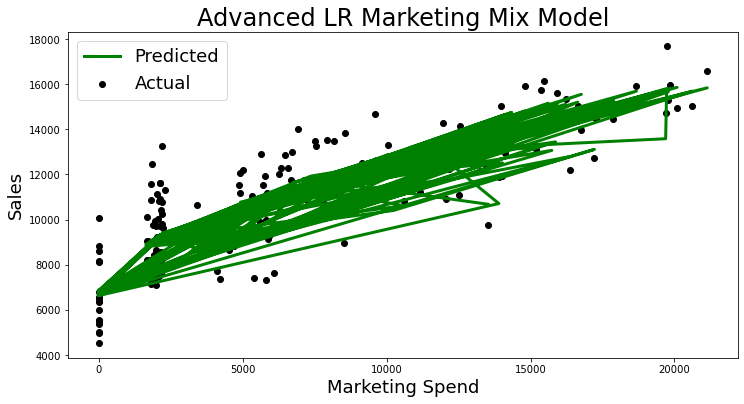

In [33]:
total_spend = X.copy()
total_spend["Spend Total"] = total_spend["TV"] + total_spend["Radio"] +total_spend["Banners"]
total_spend = total_spend[["Spend Total"]]

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(total_spend, y,color="black")
ax.plot(total_spend, tuned_model.predict(X), color="green", linewidth=3)
ax.set_xlabel("Marketing Spend",fontsize=18)
ax.set_ylabel("Sales",fontsize=18)
ax.legend(["Predicted","Actual"],fontsize=18)
ax.set_title("Advanced LR Marketing Mix Model",fontsize=24)
plt.savefig('Images/Advanced_LR_MMM.png')
;

In [29]:
pred_v_actual_df = pd.DataFrame(data=tuned_model.predict(X),columns=["Predicted Sales"],index=X.index)
pred_v_actual_df["Actual Sales"]=y

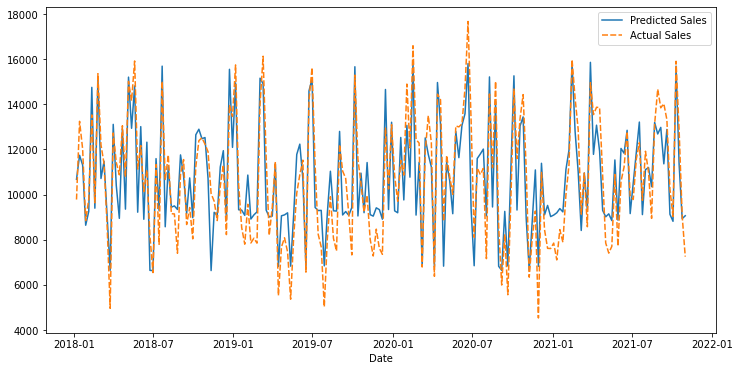

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=pred_v_actual_df);

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


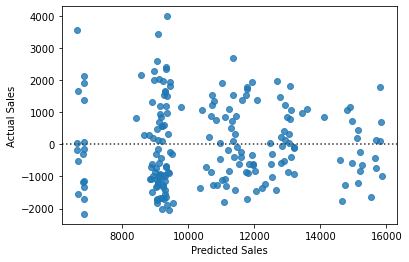

In [31]:
sns.residplot("Predicted Sales","Actual Sales",data=pred_v_actual_df);